# Initializations

In [1]:
import numpy as np
import pandas as pd

import sys, os, time
import glob

from matplotlib import pyplot as plt
%matplotlib inline

# these magics ensure that external modules that are modified are also automatically reloaded
%load_ext autoreload
%autoreload 2

# widgets and interaction
from ipywidgets import FloatProgress
from IPython.display import display, clear_output

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

import warnings
warnings.filterwarnings('ignore')

import gzip
import cPickle as pickle

from PIL import Image

import sys
sys.path.append("../ml-model/pytorch_utils")
from loader_dataframe import ImageDataFrame, grayscale_loader, WeightedRandomSampler



In [2]:
from IPython import parallel

rc = parallel.Client()
all_engines = rc[:]
lbv = rc.load_balanced_view()

print len(all_engines)

48


In [3]:
%%px --local 

from skimage.transform import resize
from skimage.io import imread, imsave

def read_img(f, imgSize=None):
    img = imread(f)
    img[img==128] = 0 # this removes gray patches that indicate no data/water bodies
    if imgSize is not None:
        img = resize(img, (imgSize, imgSize), preserve_range=True)
    img = img / img.max()
    return img

# Define & exemplify stats of interest

In [4]:
myfile = '/home/data/world-cities//train/very-large/SAR_fr_paris,-fr-(pop-2.1M)_very-large_2110694_48.8667_2.3333.png'
myfile

'/home/data/world-cities//train/very-large/SAR_fr_paris,-fr-(pop-2.1M)_very-large_2110694_48.8667_2.3333.png'

#### Fraction of occupied area

In [5]:
%%px --local 

compute_pct_occupied = lambda img: (img).sum() / float(img.shape[0]*img.shape[1])

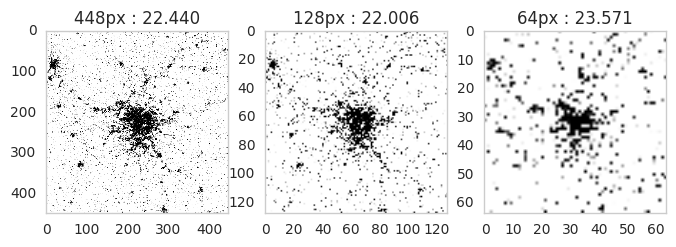

In [6]:
# using PIL (which is what torchvision uses)

img = grayscale_loader(myfile)

img_64 = img.resize((64,64))
img_128= img.resize((128,128))

fig, ax = plt.subplots(1,3, figsize=(8,4))
ax[0].imshow(img); ax[0].set_title("448px : %2.3f"%compute_pct_occupied(np.array(img)))
ax[1].imshow(img_128); ax[1].set_title("128px : %2.3f"%compute_pct_occupied(np.array(img_128)))
ax[2].imshow(img_64); ax[2].set_title("64px : %2.3f"%compute_pct_occupied(np.array(img_64)))

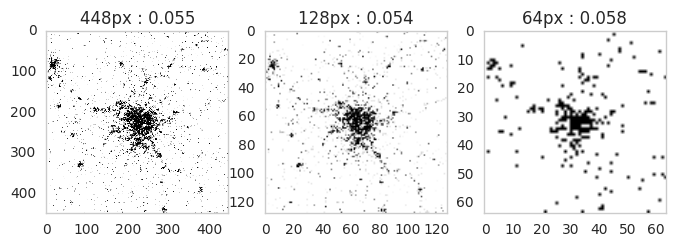

In [7]:
# using skimage

img = read_img(myfile)

img_64 = resize(img, (64,64), preserve_range=True)
img_128= resize(img, (128,128), preserve_range=True)

fig, ax = plt.subplots(1,3, figsize=(8,4))
ax[0].imshow(img); ax[0].set_title("448px : %2.3f"%compute_pct_occupied(img))
ax[1].imshow(img_128); ax[1].set_title("128px : %2.3f"%compute_pct_occupied(img_128))
ax[2].imshow(img_64); ax[2].set_title("64px : %2.3f"%compute_pct_occupied(img_64))

#### Distribution of patch areas

In [8]:
%%px --local 

from skimage import morphology

def compute_patch_areas(M):
    mask = morphology.label(M)
    areas = []
    for i in np.arange(1,mask.max()):
        areas.append((i,(mask==i).sum()))
    areas.sort(key=lambda x: x[1], reverse=True)
    return areas, mask

def compute_patch_area_distribution(img, bins=None):
    areas, mask = compute_patch_areas(img)
    area_sizes = [x[1] for x in areas]
    N_counts, bins = np.histogram(area_sizes, bins=bins)
    areas = None; mask = None; area_sizes = None
    return np.log(N_counts), bins

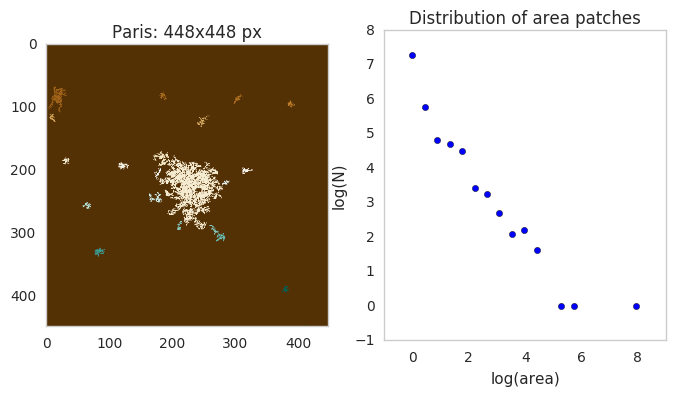

In [9]:
areas, mask = compute_patch_areas(img)

area_sizes = [x[1] for x in areas]
log_area_bins = np.logspace(np.log(min(area_sizes)), np.log(max(area_sizes)), 20, base=np.exp(1))
log_N, _ = compute_patch_area_distribution(img, bins=log_area_bins)

# plot just top 20 areas
mask1 = mask.copy()
for a in areas[20:]:
    mask1[mask1==a[0]] = 0

fig, ax = plt.subplots(1,2, figsize=(8,4))
imgplot = ax[0].imshow(mask1)
imgplot.set_cmap('BrBG')
ax[0].set_title("Paris: 448x448 px")

# plot distribution of area sizes
ax[1].scatter(np.log(log_area_bins[:-1]), log_N, marker="o")
ax[1].set_title("Distribution of area patches")
ax[1].set_ylabel("log(N)")
ax[1].set_xlabel("log(area)")

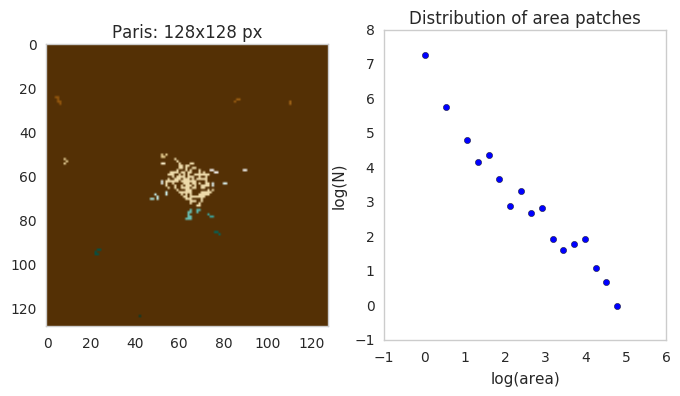

In [10]:
areas, mask = compute_patch_areas(resize(img, (128,128), preserve_range=True))

area_sizes = [x[1] for x in areas]
log_area_bins = np.logspace(np.log(min(area_sizes)), np.log(max(area_sizes)), 20, base=np.exp(1))
log_N, _ = compute_patch_area_distribution(img, bins=log_area_bins)

# plot just top 20 areas
mask1 = mask.copy()
for a in areas[20:]:
    mask1[mask1==a[0]] = 0

fig, ax = plt.subplots(1,2, figsize=(8,4))
imgplot = ax[0].imshow(mask1)
imgplot.set_cmap('BrBG')
ax[0].set_title("Paris: 128x128 px")


# plot distribution of area sizes
ax[1].scatter(np.log(log_area_bins[:-1]), log_N, marker="o")
ax[1].set_title("Distribution of area patches")
ax[1].set_ylabel("log(N)")
ax[1].set_xlabel("log(area)")

In [11]:
%%px --local 

import scipy.misc

def fractal_dimension(Z, threshold=0.9):

    # Only for 2d image
    assert(len(Z.shape) == 2)

    # From https://github.com/rougier/numpy-100 (#87)
    def boxcount(Z, k):
        S = np.add.reduceat(
            np.add.reduceat(Z, np.arange(0, Z.shape[0], k), axis=0),
                               np.arange(0, Z.shape[1], k), axis=1)

        # We count non-empty (0) and non-full boxes (k*k)
        return len(np.where((S > 0) & (S < k*k))[0])


    # Transform Z into a binary array
    Z = (Z < threshold)

    # Minimal dimension of image
    p = min(Z.shape)

    # Greatest power of 2 less than or equal to p
    n = 2**np.floor(np.log(p)/np.log(2))

    # Extract the exponent
    n = int(np.log(n)/np.log(2))

    # Build successive box sizes (from 2**n down to 2**1)
    sizes = 2**np.arange(n, 1, -1)

    # Actual box counting with decreasing size
    counts = []
    for size in sizes:
        counts.append(boxcount(Z, size))

    # Fit the successive log(sizes) with log (counts)
    coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
    sizes = None; counts = None
    return -coeffs[0]

('Minkowski-Bouligand dimension (computed): ', 1.632332986123719)
('Haussdorf dimension (theoretical):        ', 1.5849625007211563)


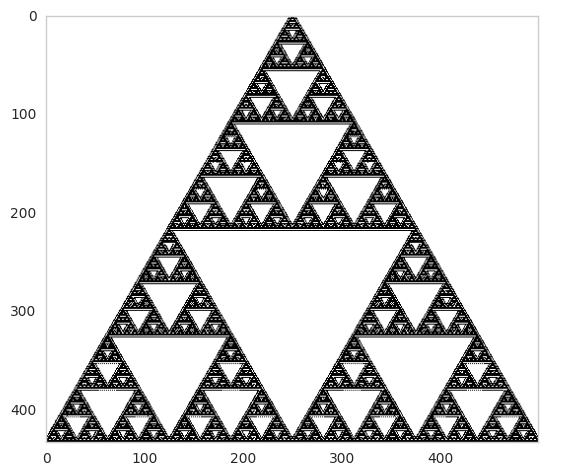

In [12]:
I = read_img("sierpinski.png")
plt.imshow(1-I)
print("Minkowski-Bouligand dimension (computed): ", fractal_dimension(I))
print("Haussdorf dimension (theoretical):        ", (np.log(3)/np.log(2)))
frac_dim = fractal_dimension(img)

In [13]:
frac_dim

1.6533453455442277

# Set up data sources: real data

In [14]:
dataroot = "/home/data/world-cities/"

#### Training data is in ./train (all cities > 10k population)

In [15]:
import glob

files = glob.glob(dataroot + "/train/*/*.png")
files_df = []
for f in files:
    s = f.split("/")
    fname, cls = s[-1], s[-2]
    _,country,city,_,pop,lat,lon = fname.split("_")
    files_df.append((f, cls, country, pop))
    
files_df = pd.DataFrame(files_df, \
                columns=["filename", "class", "country", "population"])
files_df['city'] = files_df['filename'].apply(lambda s: os.path.basename(s).split("_")[2].replace("-"," "))
files_df['phase'] = 'train'

len(files_df)

24986

#### Test data is under ./test/ and contains more carefully-filtered samples

In [16]:
files = glob.glob(dataroot + "/test/*/*.png")
test_df = []
for f in files:
    s = f.split("/")
    fname, cls = s[-1], s[-2]
    _,country,city,_,pop,lat,lon = fname.split("_")
    test_df.append((f, cls, country, pop))
    
test_df = pd.DataFrame(test_df, \
                columns=["filename", "class", "country", "population"])

# hack to remove some cities that are too close to Paris
# just an example we looked at
# this means that the filtering needs to be debugged
test_df = test_df[(~test_df['filename'].str.contains("argenteuil")) & \
                  (~test_df['filename'].str.contains("montreuil"))]

test_df['city'] = test_df['filename'].apply(lambda s: os.path.basename(s).split("_")[2].replace("-"," "))
test_df['phase'] = 'test'

len(test_df)

3010

In [ ]:
files_df = pd.concat([files_df, test_df], axis=0).reset_index().drop("index",1)

In [ ]:
regions_df = pd.read_csv("/home/data/countries_regions.csv")

country2region = {r:c for r,c in zip(regions_df['alpha-2'].str.lower(), regions_df['region'])}

files_df['region'] = files_df['country'].apply(lambda x: country2region[x] if x in country2region else np.nan)


#### Compute patch area distributions for a sample

In [ ]:
compute_max_area = lambda res: max([np.log(compute_patch_areas(resize(read_img(f), (res,res), preserve_range=True))[0][0][1])\
                        for f in files_df.sample(100)['filename']])

max_area_orig = compute_max_area(300)
max_area_128  = compute_max_area(128)
max_area_64   = compute_max_area(64)

log_area_bins_orig = np.logspace(1, max_area_orig, 20, base=np.exp(1))
log_area_bins_128 = np.logspace(1, max_area_128, 20, base=np.exp(1))
log_area_bins_64 = np.logspace(1, max_area_64, 20, base=np.exp(1))

max_area_orig, max_area_128, max_area_64

# Set up data sources: simulations

In [17]:
import glob

files_sim = glob.glob(dataroot + "/simulations/*/*.png")
files_sim_df = []
for f in files_sim:
    s = f.split("/")
    fname, cls = s[-1], s[-2]
    p = cls.split("_")
    Ue, gu, gr, T = int(p[0][2:]), float(p[1][2:]), float(p[2][2:]), float(p[3][1:])
    r = fname.replace(".png","").split("_")
    n, t = int(r[0]), int(r[1].replace("iter",""))
    files_sim_df.append((f, Ue, gu, gr, T, n, t))
    
files_sim_df = pd.DataFrame(files_sim_df, \
                columns=["filename", "Ue", "gu", "gr", "theta", "n", "t"])
files_sim_df['phase'] = 'train'

len(files_sim_df)

4115059

In [18]:
files_sel = files_sim_df[files_sim_df['theta']>0.02]\
    .groupby(['Ue', 'gu', 'gr', 'theta', 'n', 'phase'], group_keys=False)\
    .apply(lambda x: x.sort('t', ascending=False).iloc[:(len(x)/2):5])
    
print len(files_sel)

417827


In [19]:
files_sel.head()

,filename,Ue,gu,gr,theta,n,t,phase
2797247,/home/data/world-cities//simulations/Hu40_Gu2....,40,2.0,2.0,0.05,0,48,train
2797393,/home/data/world-cities//simulations/Hu40_Gu2....,40,2.0,2.0,0.05,0,33,train
2797088,/home/data/world-cities//simulations/Hu40_Gu2....,40,2.0,2.0,0.05,1,46,train
2797517,/home/data/world-cities//simulations/Hu40_Gu2....,40,2.0,2.0,0.05,1,36,train
2797117,/home/data/world-cities//simulations/Hu40_Gu2....,40,2.0,2.0,0.05,1,26,train


# Compute stats on all images

In [60]:
# myfiles_df = files_df.copy() # real images
myfiles_df = files_sel.copy() # simulated images

print len(myfiles_df)

417827


In [22]:
%%px --local

import numpy as np
import os

def compute_stats(f, imgSize=None, max_log_area=None):
    try:
        img = read_img(f.replace("//",'/'), imgSize) 
    except:
        return None, None, None, None
    pct_occupied = compute_pct_occupied(img)
    bins = np.logspace(1, max_log_area, 20, base=np.exp(1))
    log_N, _ = compute_patch_area_distribution(img, bins=bins)
    log_N[np.isinf(log_N)] = 0
    fd = fractal_dimension(img)
    
    img = None; bins = None; 
    # gc.collect()
    return f, mpct_occupied, log_N , fd

In [27]:
f = myfiles_df['filename'].iloc[0]
f

'/home/data/world-cities//simulations/Hu40_Gu2.00_Gr2.00_T0.05/0_iter48.png'

In [28]:
%%timeit  
compute_stats(f, imgSize=None, max_log_area=9.5)

10 loops, best of 3: 192 ms per loop


In [29]:
%%timeit 
compute_stats(f, imgSize=128, max_log_area=6.7)

100 loops, best of 3: 3.94 ms per loop


In [30]:
%%timeit 
compute_stats(f, imgSize=64, max_log_area=6.0)

100 loops, best of 3: 2.37 ms per loop


In [31]:
res_orig = lbv.map_async(lambda f: compute_stats(f, imgSize=None, max_log_area=9.5), \
                         myfiles_df['filename'].values.tolist())
stats_orig = pd.DataFrame(res_orig.result(), 
                          columns=["filename", "build pct", 
                                   "patch distr", "fractal dim"])

In [ ]:
res_128 = lbv.map_async(lambda f: compute_stats(f, imgSize=128, max_log_area=6.7), \
                         myfiles_df['filename'].values.tolist())
stats_128 = pd.DataFrame(res_128.result(), 
                          columns=["filename", "build pct", 
                                   "patch distr", "fractal dim"])

In [ ]:
res_64 = lbv.map_async(lambda f: compute_stats(f, imgSize=64, max_log_area=6.0), \
                         myfiles_df['filename'].values.tolist())
stats_64 = pd.DataFrame(res_64.result(), 
                          columns=["filename", "build pct", 
                                   "patch distr", "fractal dim"])

In [61]:
myfiles_df = pd.concat([myfiles_df.reset_index().drop("index",1), 
    stats_128.rename(columns={"build pct":"build pct 128", 
                               "fractal dim":"fractal dim 128",
                               "patch distr":"patch distr 128"}).drop("filename",1),
    stats_orig.rename(columns={"build pct":"build pct 448", 
                               "fractal dim":"fractal dim 448",
                               "patch distr":"patch distr 448"}).drop("filename",1),
    stats_64.rename(columns={"build pct":"build pct 64", 
                               "fractal dim":"fractal dim 64",
                               "patch distr":"patch distr 64"}).drop("filename",1)
], axis=1)

myfiles_df.dropna(inplace=True)

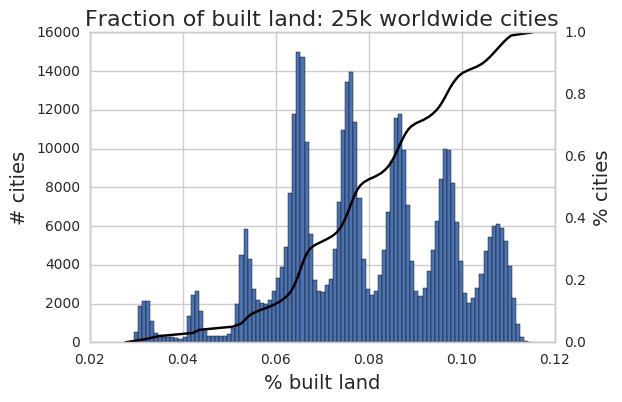

In [63]:
fig, ax = plt.subplots(figsize=(6,4))
ax2 = ax.twinx()
myfiles_df[myfiles_df['phase']=='train']['build pct 128'].hist(bins=100, ax=ax)
q = myfiles_df[myfiles_df['phase']=='train']['build pct 128'].quantile(np.linspace(0.0,1,100))
ax2.plot(q, q.index, label="cdf", color="black")
sns.set_style("whitegrid", {'axes.grid' : False})
plt.title("Fraction of built land: 25k worldwide cities", fontsize=16)
ax.set_xlabel("% built land", fontsize=14)
ax.set_ylabel("# cities", fontsize=14)
ax2.set_ylabel("% cities", fontsize=14)


In [67]:
myfiles_df.groupby("theta").apply(lambda x: x['build pct 448'].max())

theta
0.05    0.054756
0.10    0.098111
0.14    0.114756
0.18    0.115089
0.23    0.115056
0.27    0.113556
0.31    0.113111
0.36    0.114011
0.40    0.113411
dtype: float64

In [69]:
myfiles_df.groupby(["theta", "gu", "gr"]).apply(lambda x: x['t'].max())

theta  gu   gr 
0.05   2.0  2.0    48
            2.2    48
            2.4    48
            2.6    50
            2.8    50
            3.0    50
            3.2    52
            3.4    60
            3.6    66
            3.8    70
       2.2  2.0    48
            2.2    48
            2.4    50
            2.6    50
            2.8    50
            3.0    50
            3.2    52
            3.4    60
            3.6    64
            3.8    70
       2.4  2.0    48
            2.2    48
            2.4    50
            2.6    50
            2.8    50
            3.0    50
            3.2    52
            3.4    62
            3.6    68
            3.8    70
                   ..
0.40   3.4  2.0    99
            2.2    99
            2.4    99
            2.6    99
            2.8    99
            3.0    99
            3.2    99
            3.4    99
            3.6    99
            3.8    99
       3.6  2.0    99
            2.2    99
            2.4    99
            2.6 

In [ ]:
q = myfiles_df['build pct 128'].quantile(np.linspace(0.0,1,10))

print q

myfiles_df['decile'] = myfiles_df['build pct 128'].apply(lambda x: np.searchsorted(q.values, x) )

#### Save to file: real data

In [ ]:
train_df = myfiles_df[(myfiles_df['phase']=='train')]
train_df.to_csv(dataroot + "/urban_areas_over_10kpop_stats.csv")

test_df = myfiles_df[(myfiles_df['phase']=='test')]
test_df.to_csv(dataroot + "/urban_areas_over_10kpop_pruned_stats.csv")

len(train_df), len(test_df)

#### Save to file: simulations

In [70]:
train_df = myfiles_df[(myfiles_df['phase']=='train')]
train_df.to_csv(dataroot + "/simulations_stats.csv")